In [1]:
import numpy as np

import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.layers import Dense, Input, InputLayer
from tensorflow.keras import Sequential
from tensorflow.keras.models import Model
from tensorflow.keras.initializers import RandomNormal, Constant
import tensorflow
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input
from tensorflow.keras.applications.inception_v3 import InceptionV3, preprocess_input

import pickle
from numpy.linalg import norm
import matplotlib.pyplot as plt
import seaborn as sns
import os, glob, pathlib, time
import PIL
import PIL.Image

from tqdm import tqdm, tqdm_notebook

In [2]:
print(f"TensorFlow version: {tf.__version__}")

TensorFlow version: 2.5.0


In [3]:
# Check for available GPU-
gpu = tf.config.list_physical_devices('GPU')

if len(gpu) == 0:
    print(f"There are no available GPU")
else:
    print(f"Available GPU: {gpu}")

Available GPU: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
# os.getcwd()
os.listdir("/content/drive/MyDrive/")

['Getting started.pdf',
 'Colab Notebooks',
 'VGG18_Iterative_Pruning_95.43863490652879_Clustered_&_Fine_Tuned.h5',
 'Registration International Researchers.gdoc',
 'Cover_Letter-Data_Scientist.gdoc',
 'grokking-deep-reinforcement-learning_pack.zip',
 'openmoji-72x72-color.zip',
 'Resume-Data_Analyst.gdoc',
 'Resume.gdoc',
 'VGG18_summed_gradients.h5',
 'VGG18-pruned_not_trained_91.46.h5',
 'Resume-AI_ML_Engineer.gdoc',
 'Linnaeus_PhD_Presentation.gslides',
 'ResNet18_best_trained_loss.pth',
 'ResNet50__finetuned_best_trained_loss.pth',
 'Viridios_AI_Test -Task_1.ipynb',
 'Viridios_AI_Test_Task_2.ipynb',
 'DeepFashion_filenames_inceptionnetv3.pickle',
 'DeepFashion_features_inceptionnetv3.pickle',
 'img.zip',
 'DeepFashion_encoded_features_inceptionnetv3.pickle']

In [6]:
# Copy zipped image file from Google Drive to Colab directory-
!unzip "/content/drive/MyDrive/img.zip" -d "/content/"

Streaming output truncated to the last 5000 lines.
  inflating: /content/img/Woven_Dolphin_Shorts/img_00000027.jpg  
  inflating: /content/img/Woven_Dolphin_Shorts/img_00000028.jpg  
  inflating: /content/img/Woven_Dolphin_Shorts/img_00000029.jpg  
  inflating: /content/img/Woven_Dolphin_Shorts/img_00000030.jpg  
  inflating: /content/img/Woven_Dolphin_Shorts/img_00000031.jpg  
  inflating: /content/img/Woven_Dolphin_Shorts/img_00000032.jpg  
  inflating: /content/img/Woven_Dolphin_Shorts/img_00000033.jpg  
  inflating: /content/img/Woven_Dolphin_Shorts/img_00000034.jpg  
  inflating: /content/img/Woven_Dolphin_Shorts/img_00000035.jpg  
  inflating: /content/img/Woven_Dolphin_Shorts/img_00000036.jpg  
  inflating: /content/img/Woven_Dolphin_Shorts/img_00000037.jpg  
   creating: /content/img/Woven_Drawstring_Joggers/
  inflating: /content/img/Woven_Drawstring_Joggers/img_00000001.jpg  
  inflating: /content/img/Woven_Drawstring_Joggers/img_00000002.jpg  
  inflating: /content/img/Woven

In [60]:
# Read pickled Python3 list containing 2048-d extracted feature representation per image-
features_list = pickle.load(open("/content/drive/MyDrive/DeepFashion_features_inceptionnetv3.pickle", "rb"))

In [8]:
# Read pickled Python3 list containing abolute path and filenames-
filenames_list = pickle.load(open("/content/drive/MyDrive/DeepFashion_filenames_inceptionnetv3.pickle", "rb"))

In [10]:
len(features_list), len(filenames_list)

(289229, 289229)

In [11]:
# Note that the absolute path contains Google colab path-
filenames_list[1]

'/content/img/1981_Graphic_Ringer_Tee/img_00000002.jpg'

### Inception NetV3 CNN pre-trained model:

In [12]:
model_inceptionv3 = tf.keras.applications.inception_v3.InceptionV3(
    include_top = False, weights = 'imagenet',
    input_shape = (224, 224, 3), pooling = 'avg',  # or 'max'
    # classifier_activation='softmax'
)

87916544/87910968 [==============================] - 1s 0us/step


In [14]:
def extract_features(img_path, model):
    input_shape = (224, 224, 3)
    img = image.load_img(
        img_path, target_size=(input_shape[0], input_shape[1]))
    img_array = image.img_to_array(img)
    expanded_img_array = np.expand_dims(img_array, axis=0)
    preprocessed_img = preprocess_input(expanded_img_array)
    features = model_inceptionv3.predict(preprocessed_img)
    # features = model.predict(preprocessed_img)
    flattened_features = features.flatten()
    normalized_features = flattened_features / norm(flattened_features)
    return normalized_features


In [ ]:
# model_inceptionv3.summary()

In [16]:
img_path = "/content/img/Zippered_Tartan_Plaid_Flannel/"

In [17]:
# Sanity check-
features = extract_features(img_path = img_path + 'img_00000055.jpg', model = model_inceptionv3)

In [18]:
type(features), features.shape

(numpy.ndarray, (2048,))

In [19]:
print(len(features))

2048


### Autoencoder:

In [20]:
class Autoencoder(Model):
    def __init__(self):
        super(Autoencoder, self).__init__()
        
        self.encoder = Sequential([
            InputLayer(input_shape = (2048, )),
            Dense(
                units = 1024, activation = 'relu',
                kernel_initializer = tf.keras.initializers.glorot_normal(),
                use_bias = True, bias_initializer = RandomNormal(mean = 0.0, stddev = 0.05)
                 ),
            Dense(
                units = 512, activation = 'relu',
                kernel_initializer = tf.keras.initializers.glorot_normal(),
                use_bias = True, bias_initializer = RandomNormal(mean = 0.0, stddev = 0.05)
                 ),
            Dense(
                units = 256, activation = 'relu',
                kernel_initializer = tf.keras.initializers.glorot_normal(),
                use_bias = True, bias_initializer = RandomNormal(mean = 0.0, stddev = 0.05)
                 ),
            Dense(
                units = 128, activation = 'relu',
                kernel_initializer = tf.keras.initializers.glorot_normal(),
                use_bias = True, bias_initializer = RandomNormal(mean = 0.0, stddev = 0.05)
                 ),
        ])
    
        self.decoder = Sequential([
            Dense(
                units = 256, activation = 'relu',
                kernel_initializer = tf.keras.initializers.glorot_normal(),
                use_bias = True, bias_initializer = RandomNormal(mean = 0.0, stddev = 0.05)
                 ),
            Dense(
                units = 512, activation = 'relu',
                kernel_initializer = tf.keras.initializers.glorot_normal(),
                use_bias = True, bias_initializer = RandomNormal(mean = 0.0, stddev = 0.05)
                 ),
            Dense(
                units = 1024, activation = 'relu',
                kernel_initializer = tf.keras.initializers.glorot_normal(),
                use_bias = True, bias_initializer = RandomNormal(mean = 0.0, stddev = 0.05)
                 ),
            Dense(
                units = 2048, activation = 'sigmoid',
                use_bias = True, bias_initializer = RandomNormal(mean = 0.0, stddev = 0.05)
                 ),
        ])
    
    def call(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded
    
    def model(self):
        x = Input(shape=(2048,))
        return Model(inputs = [x], outputs = self.call(x))
    

In [21]:
# Initialize and build defined autoencoder-
model = Autoencoder()
model.build(input_shape = (None, 2048))

In [22]:
model.model().summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 2048)]            0         
_________________________________________________________________
sequential (Sequential)      (None, 128)               2787200   
_________________________________________________________________
sequential_1 (Sequential)    (None, 2048)              2789120   
Total params: 5,576,320
Trainable params: 5,576,320
Non-trainable params: 0
_________________________________________________________________


In [31]:
# Load pre-trained Autoencoder weights-
model.load_weights("/content/drive/MyDrive/DeepFashion_InceptionNetV3_Autoencoder_trained_weights.h5")

In [75]:
# Read pickled Python3 list containing encoded features (128-d) on top of 
# 2048-d extracted feature representation per image-
encoded_features_list = pickle.load(open("/content/drive/MyDrive/DeepFashion_encoded_features_inceptionnetv3.pickle", "rb"))

In [80]:
encoded_features = []

for enc in encoded_features_list:
    encoded_features.append(tf.reshape(tensor = encoded_features_list[0], shape = (128,)).numpy())
    # encoded_features.append(enc.reshape(128,).numpy())

In [ ]:
len(encoded_features_list), len(encoded_features), len(features_list)

In [115]:
len(encoded_features), len(features_list)

(289229, 289229)

In [ ]:
encoded_features_list[0].shape, encoded_features[0].shape, features_list[0].shape

In [83]:
del encoded_features_list

In [113]:
encoded_features[0].shape, features_list[0].shape

((128,), (2048,))

## Similarity Search:

Given a photograph, our aim is to find another photo in our dataset similar to the current one.

In [23]:
from sklearn.neighbors import NearestNeighbors

In [111]:
# Train nearest neighbor model on extracted features using Inception NetV3-
neighbors = NearestNeighbors(
    n_neighbors = 5, algorithm ='brute',
    metric = 'minkowski').fit(features_list)

In [116]:
# Train nearest neighbor model on encoded features-
neighbors_encoded = NearestNeighbors(
    n_neighbors = 5, algorithm ='brute',
    metric = 'minkowski').fit(encoded_features)

In [26]:
distances, indices = neighbors.kneighbors([features_list[0]])

In [27]:
type(distances), distances.shape, indices.shape

(numpy.ndarray, (1, 5), (1, 5))

Now you have both the indices and distances of the nearest five neighbors of the very first query feature (which represents the first image). Notice the quick execution of the first step—the training step. Unlike training most machine learning models, which can take from several minutes to hours on large datasets, instantiating the nearest-neighbor model is instantaneous because at training time there isn’t much processing. This is also called lazy learning because all the processing is deferred to classification or inference time.

Now that we know the indices, let’s see the actual image behind that feature. First, we pick an image to query, located at say, index = 0:

## Visualize __Reverse Image Search__ in action:

In [32]:
import matplotlib.image as mpimg
%matplotlib inline

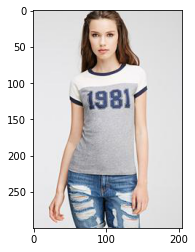

In [34]:
# VIsualize image for which image search is to be done-
plt.imshow(mpimg.imread(filenames_list[0]))

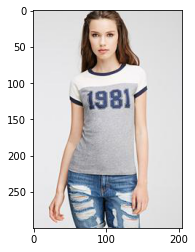

In [36]:
# Examine the nearest neighbors by plotting the first result-
plt.imshow(mpimg.imread(filenames_list[indices[0][0]]))

Wait, isn’t that a duplicate? Actually, the nearest index will be the image itself because that is what is being queried-

In [37]:
for i in range(5):
    print(distances[0][i])

4.712161e-08
0.13729234
0.48309827
0.51325256
0.5149175


This is also confirmed by the fact that the distance of the first result is zero. Now let’s plot the real first nearest neighbor-

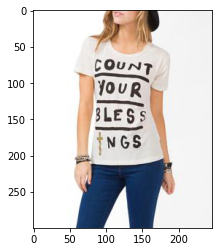

In [38]:
# Plot other similar images-
plt.imshow(mpimg.imread(filenames_list[indices[0][2]]))

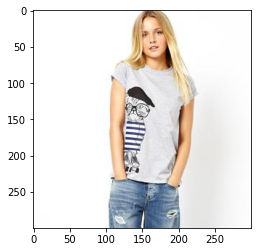

In [40]:
plt.imshow(mpimg.imread(filenames_list[indices[0][3]]))

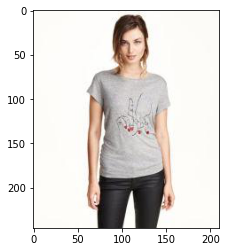

In [41]:
plt.imshow(mpimg.imread(filenames_list[indices[0][4]]))

### Choose an image at random:

In [42]:
import random

In [117]:
random_image_index = random.randint(0, len(filenames_list))

In [118]:
# Get distances and 'g' nearest neighbors using Inception NetV3 extracted features-
distances, indices = neighbors.kneighbors([features_list[random_image_index]])

In [119]:
# Get distances and 'g' nearest neighbors using Autoencoder-
distances_enc, indices_enc = neighbors_encoded.kneighbors([encoded_features[random_image_index]])

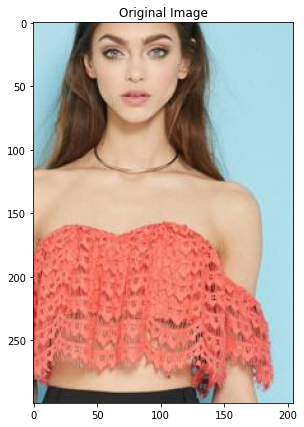

In [120]:
# Plot the original image for which reverse image search is to be performed-
plt.figure(figsize = (9, 7))

plt.title("Original Image")
plt.imshow(mpimg.imread(filenames_list[indices[0][0]]))
plt.show()

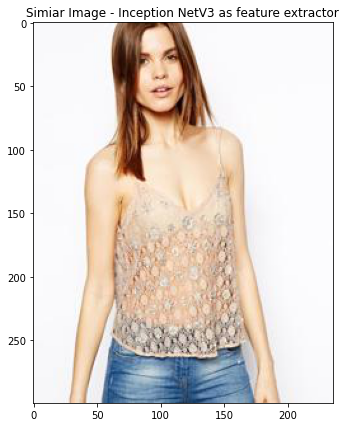

In [121]:
# Show other similar images-
plt.figure(figsize = (9, 7))

plt.title("Simiar Image - Inception NetV3 as feature extractor")
plt.imshow(mpimg.imread(filenames_list[indices[0][2]]))
plt.show()

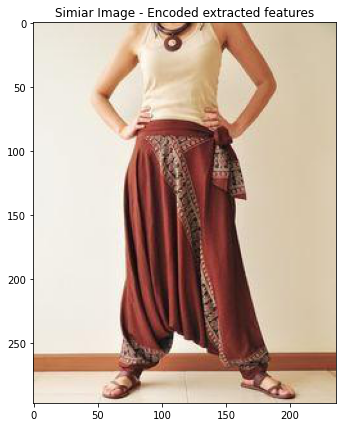

In [122]:
# Show other similar images-
plt.figure(figsize = (9, 7))

plt.title("Simiar Image - Encoded extracted features")
plt.imshow(mpimg.imread(filenames_list[indices_enc[0][2]]))
plt.show()


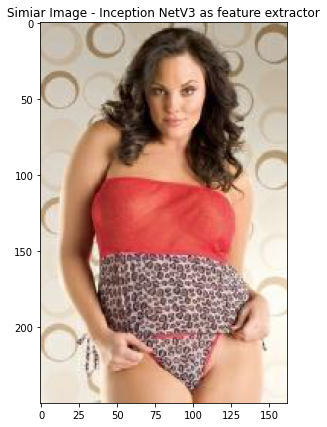

In [123]:
plt.figure(figsize = (9, 7))

plt.title("Simiar Image - Inception NetV3 as feature extractor")
plt.imshow(mpimg.imread(filenames_list[indices[0][3]]))
plt.show()


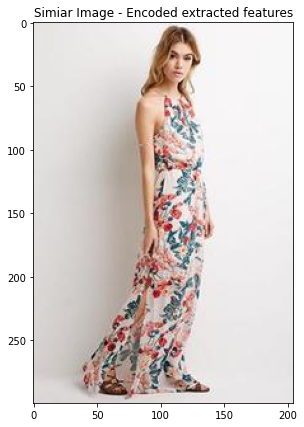

In [124]:
# Show other similar images-
plt.figure(figsize = (9, 7))

plt.title("Simiar Image - Encoded extracted features")
plt.imshow(mpimg.imread(filenames_list[indices_enc[0][3]]))
plt.show()


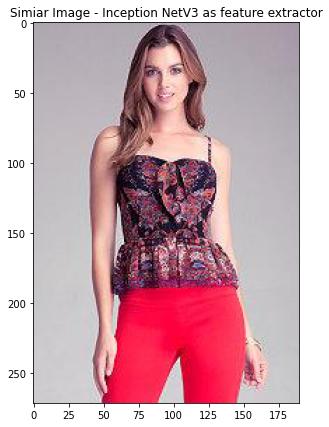

In [125]:
plt.figure(figsize = (9, 7))

plt.title("Simiar Image - Inception NetV3 as feature extractor")
plt.imshow(mpimg.imread(filenames_list[indices[0][4]]))
plt.show()


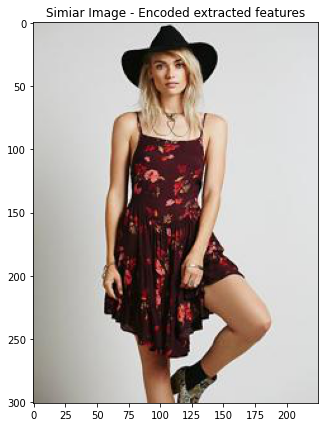

In [126]:
# Show other similar images-
plt.figure(figsize = (9, 7))

plt.title("Simiar Image - Encoded extracted features")
plt.imshow(mpimg.imread(filenames_list[indices_enc[0][4]]))
plt.show()
